## Manipulated Gender Distribution Experiments

In [ ]:
from typing import Dict, List

from config import Config, CoreConfig, DatasetConfig, ModelConfig
from datatypes import DatasetSource
from runner import ExperimentRunner

target_proportions: List[float] = [0.3, 0.5, 0.7]
num_replicates: int = 3
base_seed: int = 42

results: Dict[float, List[str]] = {}

for target_proportion in target_proportions:
    replicate_ids: List[str] = []

    for replicate_index in range(num_replicates):
        current_seed: int = base_seed + replicate_index

        core_config = CoreConfig(
            target_male_proportion=target_proportion,
            key_feature_threshold=0.3,
            random_seed=current_seed,
        )

        dataset_config = DatasetConfig(
            source_name=DatasetSource.UTKFACE,
            target_size=2000,
            image_size=48,
            use_grayscale=False,
        )

        model_config = ModelConfig(
            batch_size=32,
            epochs=5,
        )

        config = Config(
            core=core_config,
            dataset=dataset_config,
            model=model_config,
        )

        runner = ExperimentRunner(config)
        runner.run_experiment()
        replicate_ids.append(config.experiment_id)

    results[target_proportion] = replicate_ids

print(results)

In [1]:
results_map = {
    0.3: ["e5f40b34fbd079f5", "b2e35c7b6f667ce0", "9d75d113531dc530"],
    0.5: ["eb0efb69db808da9", "82be770309d2ba7a", "0278a79d268c9d7e"],
    0.7: ["8e454c677cfa65f1", "f668deaede3593b2", "2a44591a92eec02b"],
}
output_dir = "outputs"

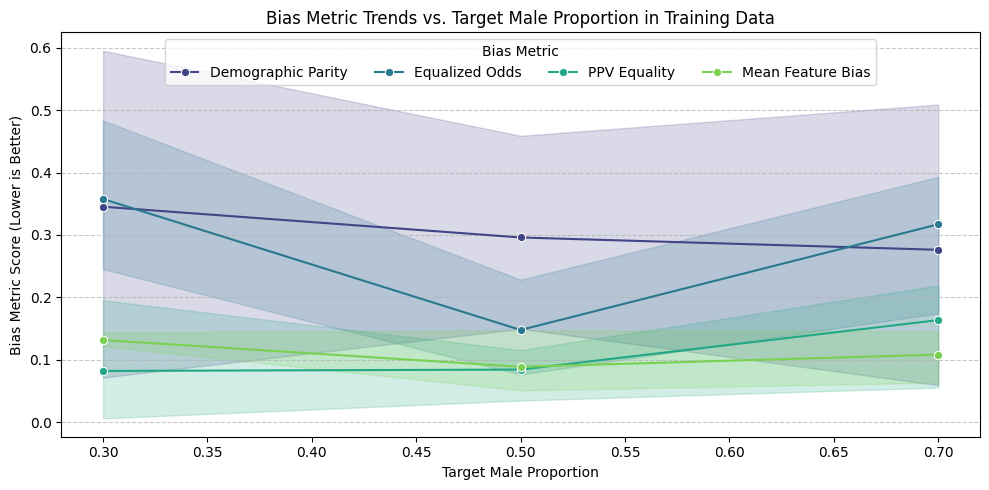

In [8]:
import json
import os
from typing import Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_bias_metric_trends(results_mapping: Dict[float, List[str]], base_path: str) -> None:
    """Plots the trend of bias metrics against the target male proportion across multiple experiments."""
    plot_data = []

    metric_display_names = {
        "demographic_parity": "Demographic Parity",
        "equalized_odds": "Equalized Odds",
        "conditional_use_accuracy_equality": "PPV Equality",
        "mean_feature_distribution_bias": "Mean Feature Bias",
    }

    for proportion, experiment_ids in results_mapping.items():
        for exp_id in experiment_ids:
            file_path = os.path.join(base_path, f"{exp_id}.json")
            try:
                with open(file_path, "r") as f:
                    result_dict = json.load(f)

                analysis = result_dict.get("analysis")
                bias_metrics = analysis.get("bias_metrics") if analysis else None

                config_proportion = result_dict.get("config", {}).get("core", {}).get("target_male_proportion")
                if config_proportion != proportion:
                    print(f"Warning: Proportion mismatch for Exp ID {exp_id}. Expected {proportion}, found {config_proportion}.")

                if bias_metrics:
                    for metric_key, metric_value in bias_metrics.items():
                        if metric_key in metric_display_names:
                            plot_data.append(
                                {
                                    "Target Male Proportion": proportion,
                                    "Metric Value": metric_value,
                                    "Bias Metric": metric_display_names[metric_key],
                                    "Experiment ID": exp_id,
                                }
                            )
                else:
                    print(f"Warning: Bias metrics not found for Experiment ID {exp_id}")

            except FileNotFoundError:
                print(f"Warning: Result file not found for Experiment ID {exp_id} at {file_path}")
            except json.JSONDecodeError:
                print(f"Warning: Could not decode JSON for Experiment ID {exp_id}")
            except Exception as e:
                print(f"Warning: An error occurred processing Experiment ID {exp_id}: {e}")

    if not plot_data:
        print("No data available for plotting bias metric trends.")
        return

    metrics_df = pd.DataFrame(plot_data)

    plt.figure(figsize=(10, 5))
    sns.lineplot(
        data=metrics_df,
        x="Target Male Proportion",
        y="Metric Value",
        hue="Bias Metric",
        marker="o",
        errorbar=("ci", 95),
        palette="viridis",
    )

    plt.title("Bias Metric Trends vs. Target Male Proportion in Training Data")
    plt.xlabel("Target Male Proportion")
    plt.ylabel("Bias Metric Score (Lower is Better)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(title="Bias Metric", loc="upper center", bbox_to_anchor=(0.5, 1), ncols=4)

    plt.tight_layout()
    plt.show()


plot_bias_metric_trends(results_map, output_dir)

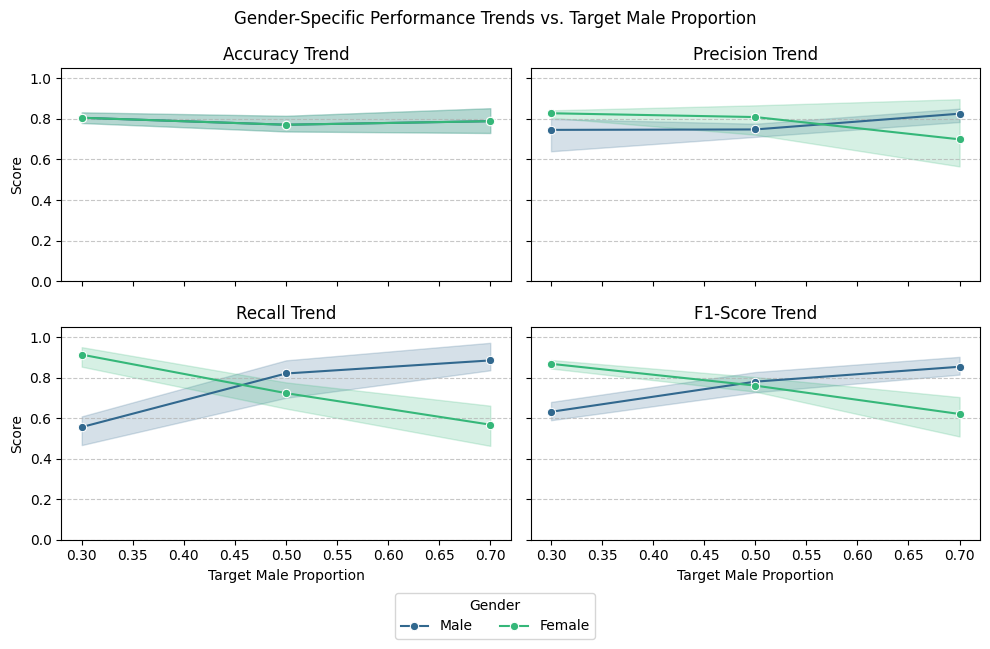

In [9]:
import json
import os
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def _calculate_perf_metrics(metrics: Dict[str, Any]) -> Dict[str, float]:
    """Helper to calculate Accuracy, Precision, Recall, F1 from TP/FP/TN/FN."""
    tp = metrics.get("tp", 0)
    fp = metrics.get("fp", 0)
    tn = metrics.get("tn", 0)
    fn = metrics.get("fn", 0)
    total = tp + fp + tn + fn

    accuracy = (tp + tn) / total if total > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
    }


def plot_performance_metric_trends(results_mapping: Dict[float, List[str]], base_path: str) -> None:
    """Plots trends of gender-specific performance metrics against target male proportion using subplots."""
    plot_data = []
    gender_keys = {"Male": "male_performance_metrics", "Female": "female_performance_metrics"}

    for proportion, experiment_ids in results_mapping.items():
        for exp_id in experiment_ids:
            file_path = os.path.join(base_path, f"{exp_id}.json")
            try:
                with open(file_path, "r") as f:
                    result_dict = json.load(f)

                analysis = result_dict.get("analysis")
                if not analysis:
                    print(f"Warning: Analysis data not found for Experiment ID {exp_id}")
                    continue

                config_proportion = result_dict.get("config", {}).get("core", {}).get("target_male_proportion")
                if config_proportion != proportion:
                    print(f"Warning: Proportion mismatch for Exp ID {exp_id}. Expected {proportion}, found {config_proportion}.")

                for gender_name, metrics_key in gender_keys.items():
                    perf_metrics = analysis.get(metrics_key)
                    if perf_metrics:
                        calculated_metrics = _calculate_perf_metrics(perf_metrics)
                        for metric_name, metric_value in calculated_metrics.items():
                            plot_data.append(
                                {
                                    "Target Male Proportion": proportion,
                                    "Metric Value": metric_value,
                                    "Performance Metric": metric_name,
                                    "Gender": gender_name,
                                    "Experiment ID": exp_id,
                                }
                            )
                    else:
                        print(f"Warning: {metrics_key} not found for Experiment ID {exp_id}")
            except FileNotFoundError:
                print(f"Warning: Result file not found for Experiment ID {exp_id} at {file_path}")
            except json.JSONDecodeError:
                print(f"Warning: Could not decode JSON for Experiment ID {exp_id}")
            except Exception as e:
                print(f"Warning: An error occurred processing Experiment ID {exp_id}: {e}")

    if not plot_data:
        print("No data available for plotting performance metric trends.")
        return

    metrics_df = pd.DataFrame(plot_data)

    metric_list = ["Accuracy", "Precision", "Recall", "F1-Score"]
    num_metrics = len(metric_list)

    ncols = 2
    nrows = (num_metrics + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3 * nrows), sharex=True)
    axes = axes.flatten()

    for i, metric_name in enumerate(metric_list):
        ax = axes[i]
        metric_subset_df = metrics_df[metrics_df["Performance Metric"] == metric_name]

        if metric_subset_df.empty:
            ax.set_title(f"{metric_name}\n(No Data)")
            ax.set_yticks([])
            continue

        sns.lineplot(
            data=metric_subset_df,
            x="Target Male Proportion",
            y="Metric Value",
            hue="Gender",
            marker="o",
            errorbar=("ci", 95),
            ax=ax,
            palette="viridis",
        )

        ax.set_title(f"{metric_name} Trend")

        if i % 2 != 0:
            ax.set_ylabel("")
            ax.set_yticklabels([])
        else:
            ax.set_ylabel("Score")

        ax.set_xlabel("Target Male Proportion")
        ax.set_ylim(0, 1.05)
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        ax.get_legend().remove()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Gender", loc="lower center", bbox_to_anchor=(0.5, -0.08), ncol=2)

    fig.suptitle("Gender-Specific Performance Trends vs. Target Male Proportion")
    plt.tight_layout()
    plt.show()


plot_performance_metric_trends(results_map, output_dir)

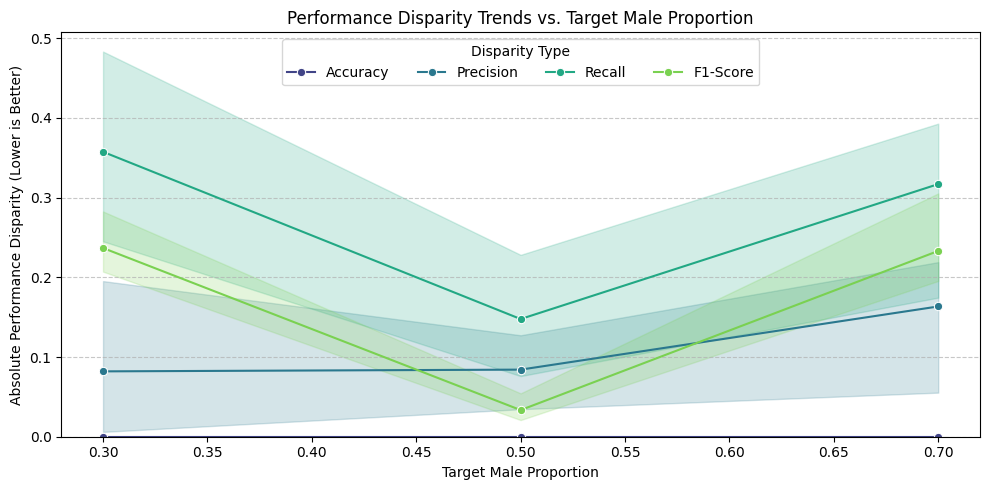

In [14]:
import json
import os
from typing import Any, Dict, List, Optional

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def _calculate_perf_metrics(metrics: Optional[Dict[str, Any]]) -> Optional[Dict[str, float]]:
    """Helper to calculate Accuracy, Precision, Recall, F1 from TP/FP/TN/FN."""
    if not metrics:
        return None

    tp = metrics.get("tp", 0)
    fp = metrics.get("fp", 0)
    tn = metrics.get("tn", 0)
    fn = metrics.get("fn", 0)
    total = tp + fp + tn + fn

    accuracy = (tp + tn) / total if total > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
    }


def plot_disparity_trends(results_mapping: Dict[float, List[str]], base_path: str) -> None:
    """Plots trends of the absolute difference between male and female performance metrics."""
    plot_data = []

    metric_list = ["Accuracy", "Precision", "Recall", "F1-Score"]

    for proportion, experiment_ids in results_mapping.items():
        for exp_id in experiment_ids:
            file_path = os.path.join(base_path, f"{exp_id}.json")
            try:
                with open(file_path, "r") as f:
                    result_dict = json.load(f)

                analysis = result_dict.get("analysis")
                if not analysis:
                    print(f"Warning: Analysis data not found for Experiment ID {exp_id}")
                    continue

                config_proportion = result_dict.get("config", {}).get("core", {}).get("target_male_proportion")
                if config_proportion != proportion:
                    print(f"Warning: Proportion mismatch for Exp ID {exp_id}. Expected {proportion}, found {config_proportion}.")

                male_metrics_raw = analysis.get("male_performance_metrics")
                female_metrics_raw = analysis.get("female_performance_metrics")

                male_metrics_calc = _calculate_perf_metrics(male_metrics_raw)
                female_metrics_calc = _calculate_perf_metrics(female_metrics_raw)

                if male_metrics_calc and female_metrics_calc:
                    for metric_name in metric_list:
                        disparity = abs(male_metrics_calc[metric_name] - female_metrics_calc[metric_name])
                        plot_data.append(
                            {
                                "Target Male Proportion": proportion,
                                "Disparity Value": disparity,
                                "Disparity Type": f"{metric_name}",
                                "Experiment ID": exp_id,
                            }
                        )
                else:
                    print(f"Warning: Missing male or female performance metrics for Experiment ID {exp_id}")
            except FileNotFoundError:
                print(f"Warning: Result file not found for Experiment ID {exp_id} at {file_path}")
            except json.JSONDecodeError:
                print(f"Warning: Could not decode JSON for Experiment ID {exp_id}")
            except Exception as e:
                print(f"Warning: An error occurred processing Experiment ID {exp_id}: {e}")

    if not plot_data:
        print("No data available for plotting performance disparity trends.")
        return

    disparity_df = pd.DataFrame(plot_data)

    plt.figure(figsize=(10, 5))
    sns.lineplot(
        data=disparity_df,
        x="Target Male Proportion",
        y="Disparity Value",
        hue="Disparity Type",
        marker="o",
        errorbar=("ci", 95),
        palette="viridis",
    )

    plt.title("Performance Disparity Trends vs. Target Male Proportion")
    plt.xlabel("Target Male Proportion")
    plt.ylabel("Absolute Performance Disparity (Lower is Better)")
    plt.ylim(bottom=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(title="Disparity Type", bbox_to_anchor=(0.5, 1), loc="upper center", ncol=4)

    plt.tight_layout()
    plt.show()


plot_disparity_trends(results_map, output_dir)

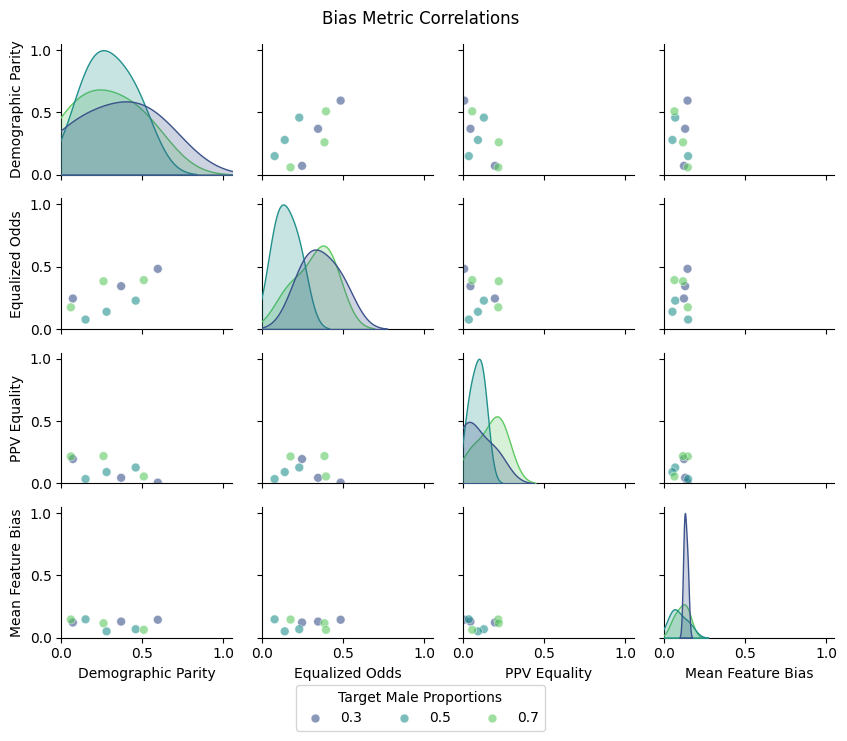

In [15]:
import json
import os
from typing import Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_bias_metric_correlation(results_mapping: Dict[float, List[str]], base_path: str) -> None:
    """Plots a matrix of scatter plots showing correlations between bias metrics."""
    plot_data = []

    metric_display_names = {
        "demographic_parity": "Demographic Parity",
        "equalized_odds": "Equalized Odds",
        "conditional_use_accuracy_equality": "PPV Equality",
        "mean_feature_distribution_bias": "Mean Feature Bias",
    }

    for proportion, experiment_ids in results_mapping.items():
        for exp_id in experiment_ids:
            file_path = os.path.join(base_path, f"{exp_id}.json")
            try:
                with open(file_path, "r") as f:
                    result_dict = json.load(f)

                analysis = result_dict.get("analysis")
                bias_metrics = analysis.get("bias_metrics") if analysis else None

                config_proportion = result_dict.get("config", {}).get("core", {}).get("target_male_proportion")
                if config_proportion != proportion:
                    print(f"Warning: Proportion mismatch for Exp ID {exp_id}. Expected {proportion}, found {config_proportion}.")

                if bias_metrics:
                    record = {"Target Male Proportion": proportion, "Experiment ID": exp_id}
                    valid_record = True
                    for metric_key, display_name in metric_display_names.items():
                        if metric_key in bias_metrics:
                            record[display_name] = bias_metrics[metric_key]
                        else:
                            print(f"Warning: Metric '{metric_key}' not found in bias_metrics for Exp ID {exp_id}")
                            valid_record = False
                            break
                    if valid_record:
                        plot_data.append(record)
                else:
                    print(f"Warning: Bias metrics not found for Experiment ID {exp_id}")

            except FileNotFoundError:
                print(f"Warning: Result file not found for Experiment ID {exp_id} at {file_path}")
            except json.JSONDecodeError:
                print(f"Warning: Could not decode JSON for Experiment ID {exp_id}")
            except Exception as e:
                print(f"Warning: An error occurred processing Experiment ID {exp_id}: {e}")

    if not plot_data:
        print("No data available for plotting bias metric correlations.")
        return

    if len(plot_data) < 2:
        print("Need at least two data points to plot correlations.")
        return

    metrics_df = pd.DataFrame(plot_data)

    plot_vars = list(metric_display_names.values())
    hue_var = "Target Male Proportion"

    metrics_df[hue_var] = metrics_df[hue_var].astype("category")

    g = sns.pairplot(
        metrics_df,
        vars=plot_vars,
        hue=hue_var,
        palette="viridis",
        diag_kind="kde",
        plot_kws={"alpha": 0.6, "s": 40},
        height=1.75,
    )

    g._legend.remove()
    g.figure.suptitle("Bias Metric Correlations")

    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.figure.legend(
        title="Target Male Proportions",
        handles=handles,
        labels=labels,
        loc="lower center",
        ncol=3,
        bbox_to_anchor=(0.5, -0.06),
    )

    for ax in g.axes.flatten():
        ax.set_ylim(0, 1.05)
        ax.set_xlim(0, 1.05)

    plt.tight_layout()
    plt.show()


plot_bias_metric_correlation(results_map, output_dir)

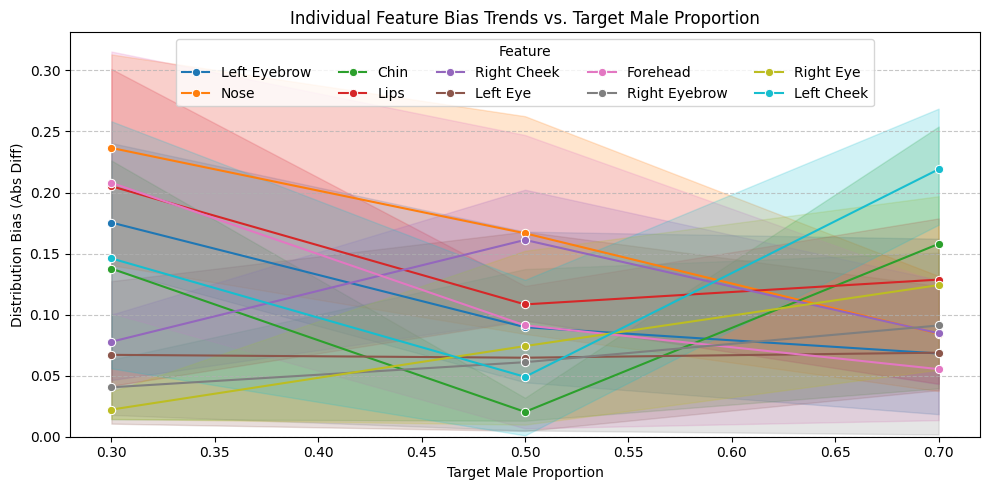

In [ ]:
import json
import os
from typing import Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_feature_bias_trends(results_mapping: Dict[float, List[str]], base_path: str) -> None:
    """Plots the trend of distribution bias for individual features against target male proportion."""
    plot_data = []

    for proportion, experiment_ids in results_mapping.items():
        for exp_id in experiment_ids:
            file_path = os.path.join(base_path, f"{exp_id}.json")
            try:
                with open(file_path, "r") as f:
                    result_dict = json.load(f)

                analysis = result_dict.get("analysis")
                if not analysis:
                    print(f"Warning: Analysis data not found for Experiment ID {exp_id}")
                    continue

                feature_distributions = analysis.get("feature_distributions")
                if not feature_distributions:
                    print(f"Warning: Feature distributions not found for Experiment ID {exp_id}")
                    continue

                config_proportion = result_dict.get("config", {}).get("core", {}).get("target_male_proportion")
                if config_proportion != proportion:
                    print(f"Warning: Proportion mismatch for Exp ID {exp_id}. Expected {proportion}, found {config_proportion}.")

                for dist_data in feature_distributions:
                    feature_name = dist_data.get("feature")
                    distribution_bias = dist_data.get("distribution_bias")

                    if feature_name and distribution_bias is not None:
                        display_name = feature_name.replace("_", " ").title()
                        plot_data.append(
                            {
                                "Target Male Proportion": proportion,
                                "Distribution Bias": distribution_bias,
                                "Feature": display_name,
                                "Experiment ID": exp_id,
                            }
                        )
                    else:
                        print(f"Warning: Missing feature name or bias value in distribution data for Exp ID {exp_id}")

            except FileNotFoundError:
                print(f"Warning: Result file not found for Experiment ID {exp_id} at {file_path}")
            except json.JSONDecodeError:
                print(f"Warning: Could not decode JSON for Experiment ID {exp_id}")
            except Exception as e:
                print(f"Warning: An error occurred processing Experiment ID {exp_id}: {e}")

    if not plot_data:
        print("No data available for plotting feature bias trends.")
        return

    feature_bias_df = pd.DataFrame(plot_data)

    plt.figure(figsize=(10, 5))
    sns.lineplot(
        data=feature_bias_df,
        x="Target Male Proportion",
        y="Distribution Bias",
        hue="Feature",
        marker="o",
        errorbar=("ci", 95),
        palette="tab10",
    )

    plt.title("Individual Feature Bias Trends vs. Target Male Proportion")
    plt.xlabel("Target Male Proportion")
    plt.ylabel("Distribution Bias (Abs Diff)")
    plt.ylim(bottom=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(title="Feature", bbox_to_anchor=(0.5, 1), loc="upper center", ncol=5)

    plt.tight_layout()
    plt.show()


plot_feature_bias_trends(results_map, output_dir)